## Support Vector Machine

Let's train a SVM model to detect **Iris virginica** flowers:
- load the iris dataset, 
- scale the features,
- train a linear SVM model, using the LinearSVC class with C=1 and the hinge loss function 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.pipeline import Pipeline

In [2]:
from sklearn.preprocessing import StandardScaler 
from sklearn.svm import LinearSVC
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)] # petal length, petal width
y = (iris["target"] == 2).astype(np.float64) # Iris virginica

In [3]:
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)
scaled_svm_clf1 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ])
scaled_svm_clf1.fit(X, y)

/Users/Gizem/anaconda3/envs/islp/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge', random_state=42))])

In [4]:
svm_clf1.predict([[5.5, 1.7]])

array([1.])

### What is happening behind the scene?
A trained LinearSVC model basically computes decision_function = w1.x1 + w2.x2 + ...+ wn.xn + b, and if decision_function ≥ 0, then the instance is classified as positive, or else it's classified as negative. x1, x2, ..., xn are the scaled input features and w1, w2, ..., wn are the corresponding weights, and b is the bias term.

In [5]:
# Convert to unscaled parameters
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf1.coef_ = np.array([w1])

#### Finding the support vectors

The support vectors are the ones that are not on or in the margin. In other words, it's any positive instance whose score is <1, or any negative instance whose score is >-1. It's a linear model, the score is simply w1 x1 + w2 x2 + ... + wn xn + b, and we can compute the scores for many instances at once by computing X.dot(w) + b, where X is the input matrix and w is the weight vector. If y is the target vector, 0 for each negative instance and 1 for each positive instance, then t = 2 * y - 1 defines a new target vector, with -1 for each negative instance, and 1 for each positive instance.

We want:

    X.dot(w) + b < -1 for negative instances
    X.dot(w) + b > 1 for positive instances

We can rewrite this as:

    -1 * X.dot(w) + b) > 1 for negative instances
    +1 * X.dot(w) + b > 1 for positive instances

So this simplifies to:

We can rewrite this as:

    t * X.dot(w) + b) > 1 for all instances

The code below finds these instances and ravel() function just reshapes the array to a one-dimensional array:

In [6]:
# Find support vectors (LinearSVC does not do this automatically)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]

In [7]:
svm_clf1.support_vectors_

array([[4.5, 1.5],
       [4.9, 1.5],
       [4.6, 1.5],
       [4.7, 1.6],
       [4.5, 1.5],
       [4.5, 1.5],
       [4.8, 1.8],
       [4.9, 1.5],
       [4.8, 1.4],
       [5. , 1.7],
       [4.5, 1.5],
       [5.1, 1.6],
       [4.5, 1.5],
       [4.5, 1.6],
       [4.7, 1.5],
       [5.1, 1.9],
       [4.5, 1.7],
       [5.5, 1.8],
       [5. , 1.5],
       [4.9, 1.8],
       [4.8, 1.8],
       [4.9, 1.8],
       [5.8, 1.6],
       [5.1, 1.5],
       [5.6, 1.4],
       [5.5, 1.8],
       [4.8, 1.8],
       [5.1, 1.9],
       [5. , 1.9],
       [5.1, 1.8]])

In [8]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    b11 = decision_boundary + margin
    b12 = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, b11, "k--", linewidth=2)
    plt.plot(x0, b12, "k--", linewidth=2)

(4.0, 6.0, 0.8, 2.8)

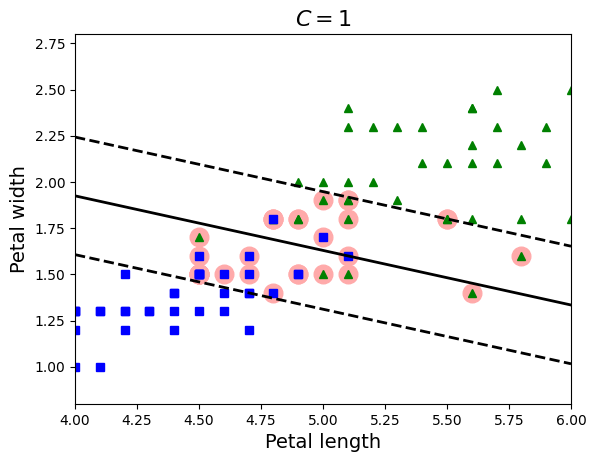

In [9]:
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris-Virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris-Versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 6, 0.8, 2.8])

The instances with the red-ish hue represent the support vectors, used in defining the decision boundary. Though the total is 28, we see the unique 19 on the graph, rest are not visible due to overlap.

### SVM Hyperparameters, ```C```

If our SVM model is overfitting, we can use the parameter ```C``` to regularize it.

Setting ```C``` to a low value creates a more flexible model. With a high value the model favors a narrower margin and less margin violations. Margin violations are bad. It’s usually better to have few of them. However, in this case the model with a ```C=1``` inspite of many margin violations will probably generalize better.

#### Increasing ```C```
The code is similar to the one above, except the we have ```C=100``` and ```max_iter=10000```.

In [10]:
svm_clf2 = LinearSVC(C=100, loss="hinge",random_state=42,max_iter=10000)
scaled_svm_clf2 = Pipeline([
            ("scaler", StandardScaler()),
            ("linear_svc", svm_clf2),
        ])
scaled_svm_clf2.fit(X, y)

# Convert to unscaled parameters
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf2.intercept_ = np.array([b2])
svm_clf2.coef_ = np.array([w2])
# Find support vectors (LinearSVC does not do this automatically)
t = y * 2 - 1
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf2.support_vectors_ = X[support_vectors_idx2]

/Users/Gizem/anaconda3/envs/islp/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


(4.0, 6.0, 0.8, 2.8)

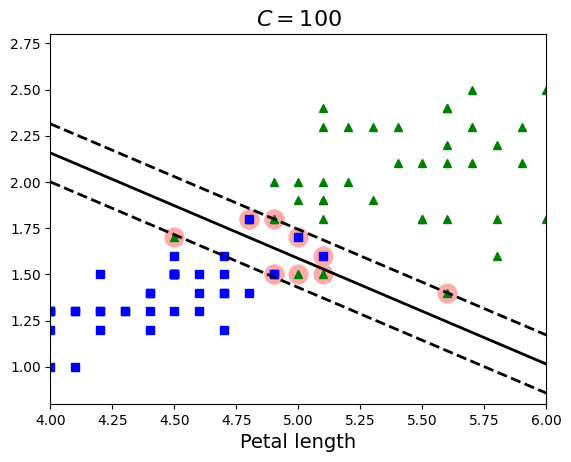

In [11]:
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 6, 0.8, 2.8])

The higher ```C``` value resulted in a much tighter margin, less number of margin violations.